In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
if os.getcwd() != '/content/drive/My Drive/Tropical_Cyclones_Thesis/ERA5_Dataset':
  os.chdir('./drive/MyDrive/Tropical_Cyclones_Thesis/ERA5_Dataset')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from keras.models import load_model

In [2]:
rules = '''IF P_Mean_101869.69028207177_to_102474.83694889088 > 0.5 THEN probability of class 1: 0.1% (0.0%-0.2%)
ELSE IF P_Mean_101628.23226090326_to_101869.69028207177 > 0.5 THEN probability of class 1: 0.0% (0.0%-0.1%)
ELSE IF Vor_850hPa_Mean_6.591279132241032e-06_to_2.014001955415997e-05 > 0.5 THEN probability of class 1: 0.2% (0.0%-0.7%)
ELSE IF Wind_300hPa_Mean_21.93199469719262_to_27.61271385188318 > 0.5 THEN probability of class 1: 0.5% (0.1%-1.3%)
ELSE IF Wind_1000hPa_Std_0.4353356986005566_to_1.1962253797942326 > 0.5 THEN probability of class 1: 0.3% (0.1%-0.6%)
ELSE IF P_Std_118.64628705637469_to_165.90666745508562 > 0.5 and Vor_850hPa_Mean_2.3306086875410474e-06_to_6.591279132241032e-06 > 0.5 THEN probability of class 1: 1.1% (0.4%-2.1%)
ELSE IF Wind_850hPa_Std_0.6379293526946854_to_1.6797814845699877 > 0.5 THEN probability of class 1: 1.0% (0.5%-1.9%)
ELSE IF P_Std_165.90666745508562_to_214.55995053718138 > 0.5 and Wind_Gust_Mean_12.74573983140615_to_14.674861761381507 > 0.5 THEN probability of class 1: 4.4% (1.6%-8.4%)
ELSE IF T_1000hPa_Mean_294.7662664392403_to_295.92441335424525 > 0.5 THEN probability of class 1: 0.6% (0.1%-1.8%)
ELSE IF Wind_850hPa_Std_1.6797814845699877_to_2.20498289108132 > 0.5 THEN probability of class 1: 2.4% (1.5%-3.4%)
ELSE IF Wind_300hPa_Std_7.613552005620761_to_9.180567608085411 > 0.5 THEN probability of class 1: 5.1% (1.4%-11.0%)
ELSE IF P_Std_26.90104051539957_to_118.64628705637469 > 0.5 THEN probability of class 1: 7.7% (4.4%-11.9%)
ELSE IF Wind_300hPa_Mean_17.3500105731529_to_21.93199469719262 > 0.5 THEN probability of class 1: 4.7% (1.3%-10.0%)
ELSE IF Vor_850hPa_Std_7.512551958095957e-06_to_2.1320930339677047e-05 > 0.5 THEN probability of class 1: 9.2% (5.4%-13.9%)
ELSE IF Vor_850hPa_Std_2.1320930339677047e-05_to_2.895411398714183e-05 > 0.5 THEN probability of class 1: 14.2% (10.3%-18.7%)
ELSE IF Vor_850hPa_Mean_-1.954284361190437e-06_to_2.3306086875410474e-06 > 0.5 THEN probability of class 1: 21.1% (13.4%-30.1%)
ELSE IF Vor_850hPa_Std_2.895411398714183e-05_to_3.8940293109154884e-05 > 0.5 THEN probability of class 1: 35.8% (29.6%-42.3%)
ELSE IF Vor_850hPa_Mean_-8.816371315800296e-06_to_-1.954284361190437e-06 > 0.5 THEN probability of class 1: 52.4% (40.1%-64.5%)
ELSE probability of class 1: 88.3% (84.7%-91.6%)'''

In [11]:
# graphviz is installed already, but need lib too
!apt install libgraphviz-dev
!pip install pygraphviz

['IF P_Mean_101869.69028207177_to_102474.83694889088 > 0.5 THEN probability of class 1: 0.1% (0.0%-0.2%)', 'ELSE IF P_Mean_101628.23226090326_to_101869.69028207177 > 0.5 THEN probability of class 1: 0.0% (0.0%-0.1%)', 'ELSE IF Vor_850hPa_Mean_6.591279132241032e-06_to_2.014001955415997e-05 > 0.5 THEN probability of class 1: 0.2% (0.0%-0.7%)', 'ELSE IF Wind_300hPa_Mean_21.93199469719262_to_27.61271385188318 > 0.5 THEN probability of class 1: 0.5% (0.1%-1.3%)', 'ELSE IF Wind_1000hPa_Std_0.4353356986005566_to_1.1962253797942326 > 0.5 THEN probability of class 1: 0.3% (0.1%-0.6%)', 'ELSE IF P_Std_118.64628705637469_to_165.90666745508562 > 0.5 and Vor_850hPa_Mean_2.3306086875410474e-06_to_6.591279132241032e-06 > 0.5 THEN probability of class 1: 1.1% (0.4%-2.1%)', 'ELSE IF Wind_850hPa_Std_0.6379293526946854_to_1.6797814845699877 > 0.5 THEN probability of class 1: 1.0% (0.5%-1.9%)', 'ELSE IF P_Std_165.90666745508562_to_214.55995053718138 > 0.5 and Wind_Gust_Mean_12.74573983140615_to_14.6748617

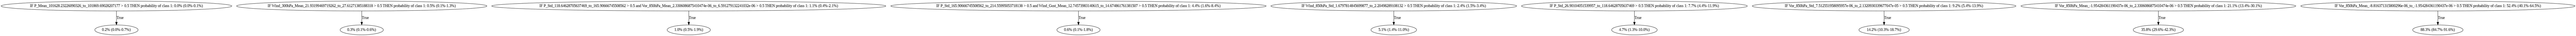

In [16]:
import pygraphviz as pgv
from IPython.display import Image

# Create a directed graph
graph = pgv.AGraph(strict=True, directed=True)

# Add nodes and edges based on rules
lines = rules.split('\n')
print(lines)
for i in range(1, len(lines) - 1, 2):
    condition = lines[i].replace('ELSE ', '')
    probability = lines[i + 1].split(':')[1].strip()
    graph.add_node(condition, label=condition)
    graph.add_node(probability, label=probability)
    graph.add_edge(condition, probability, label='True')

# Save the graph to a file
graph_file_path = 'decision_tree.png'
graph.draw(graph_file_path, prog='dot', format='png')

# Display the image
Image(graph_file_path)